# LNP Model


This is a JAX implementation of a linear-nonlinear-Poisson (LNP) model (see [Pillow _et al._ (2008)](https://www.nature.com/articles/nature07140)) used to fit two-photon zebrafish calcium fluorescence data.


### Parameters

The hyperparameters are
* $N$: Number of neurons.
* $M$: Number of time steps in the input.
* $dh$: Number of time steps to consider for convolution.
* $ds$: Number of stimuli
* $dt$: Time per step (seconds).

The weights are

* $\theta_h$ ($N \times dh$ matrix) is the temporal coupling weight.
* $\theta_w$ ($N \times N$ matrix) is the coupling between neurons.
* $\theta_b$ ($N \times 1$ matrix) is the base firing rate for each cell.
* $\theta_s$ ($N \times ds$ matrix) is the cell's response to each stimulus.

The inputs are:
* $y$ is an $N \times M$ matrix that contains spiking rate.
* $s$ is a $ds \times M$ matrix that contains the stimulus data.

### Model

Let $h(y)$ be a sliding window convolution between $\theta_h$ and $y$. 
$$
h(y) = \theta_h * y(:,i).
$$

Then, the predicted activity $\hat{r}$ (a vector of length $N$) for the next time step is
$$
\hat{r}(y, s) = dt \times \exp\left\{\theta_ks + h(y) + \theta_wy + \theta_b \right\}. \\
$$

The log-likelihood is
$$
\ell(y, \hat{r}) = \frac{1}{MN} \left( \hat{r} - \sum_{i=0}^N y_i \odot \log(\hat{r}) \right).
$$

### Implementation

The model is coded for the just-in-time (JIT) compiler of JAX for speed and automatic differentiation.

The compiler needs to know the exact dimensions of all matrices that are passed into each function. Direct substitutions are not allowed as it disrupts the model differentiability.

Any changes in input dimensions will lead to a recompilation which destroys all speed benefit. Hence, the hyperparameter $M$ or $M_{\text{lim}}$ is assumed to be fixed. As the number of detected neurons do increase through the run, $N_{\text{lim}}$ will automatically increase by 2-fold when the dimensions of $y$ and $s$ exceed $N_{\text{lim}}$. Extra space in the weight matrices $\theta$ are padded with 0.

### Data

Download `tbif_batch_for_analysis.pk` from the `improv Data Sharing` folder. This is a pickled file of `y` and `s` processed through `CaImAN` from `08-17-14_1437_F1_6dpfCOMPLETESET_WB_overclimbing_z-1.tbif`.

Using CaImAn from `pearsonlab/CaImAn`, branch `lite`, commit `c28094ea5b3becd2818a4e0677e5fd9b08a1e6b4`. The parameters are as followed.
'fr': 2,
'decay_time': 0.8,
'gSig': (3,3),
'p': 1,
'min_SNR': 1.5,
'rval_thr': 1,
'ds_factor': 1,
'nb': 2,
'motion_correct': True,
'init_batch': 100,
'init_method': 'bare',
'normalize': True,
'sniper_mode': True,
'K': 10,
'epochs': 1,
'max_shifts_online': np.ceil(10).astype('int'),
'pw_rigid': False,
'dist_shape_update': True,
'show_movie': False,
'update_freq': 50,
'minibatch_shape': 100,
'output': 'outputEstimates'}

### Optimizer Comparison

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from compare_opt import CompareOpt

sns.set()

params = {'dh': 10, 'ds': 8, 'dt': 0.5, 'n': 0, 'N_lim': 200}  # M_lim depends on online/offline.
optimizers = [
    {'name': 'sgd', 'step_size': 1e-5},
    {'name': 'sgd', 'step_size': 1e-5, 'offline': True},
    {'name': 'nesterov', 'step_size': 1e-5, 'mass': 0.9},
    {'name': 'nesterov', 'step_size': 1e-5, 'mass': 0.9, 'offline': True},
    {'name': 'adam', 'step_size': 1e-5},
    {'name': 'adam', 'step_size': 1e-5, 'offline': True},
    {'name': 'adagrad', 'step_size': 1e-5, 'momentum': 0.9},
    {'name': 'adagrad', 'step_size': 1e-5, 'momentum': 0.9, 'offline': True},
    {'name': 'rmsprop_momentum', 'step_size': 1e-5},
    {'name': 'rmsprop_momentum', 'step_size': 1e-5, 'offline': True},
]

c = CompareOpt(params=params, file='tbif_batch_for_analysis.pk')

In [2]:
lls = c.run(optimizers, save_grad=False, save_theta=False)

Using CPU_0
Optimizer: {'name': 'sgd', 'step_size': 1e-05}
sgd, step: 0
sgd, step: 100
sgd, step: 200
sgd, step: 300
sgd, step: 400
sgd, step: 500
sgd, step: 600
sgd, step: 700
sgd, step: 800
sgd, step: 900
sgd, step: 1000
sgd, step: 1100
sgd, step: 1200
sgd, step: 1300
sgd, step: 1400
sgd, step: 1500
sgd, step: 1600
sgd, step: 1700
sgd, step: 1800
sgd, step: 1900
sgd, step: 2000
sgd, step: 2100
sgd, step: 2200
sgd, step: 2300
sgd, step: 2400
sgd, step: 2500
sgd, step: 2600
sgd, step: 2700
sgd, step: 2800
sgd: 0.003899 s/step
Using CPU_0
Optimizer: {'name': 'sgd', 'step_size': 1e-05}
sgd, step: 0
sgd, step: 100
sgd, step: 200
sgd, step: 300
sgd, step: 400
sgd, step: 500
sgd, step: 600
sgd, step: 700
sgd, step: 800
sgd, step: 900
sgd, step: 1000
sgd, step: 1100
sgd, step: 1200
sgd, step: 1300
sgd, step: 1400
sgd, step: 1500
sgd, step: 1600
sgd, step: 1700
sgd, step: 1800
sgd, step: 1900
sgd, step: 2000
sgd, step: 2100
sgd, step: 2200
sgd, step: 2300
sgd, step: 2400
sgd, step: 2500
sgd, 

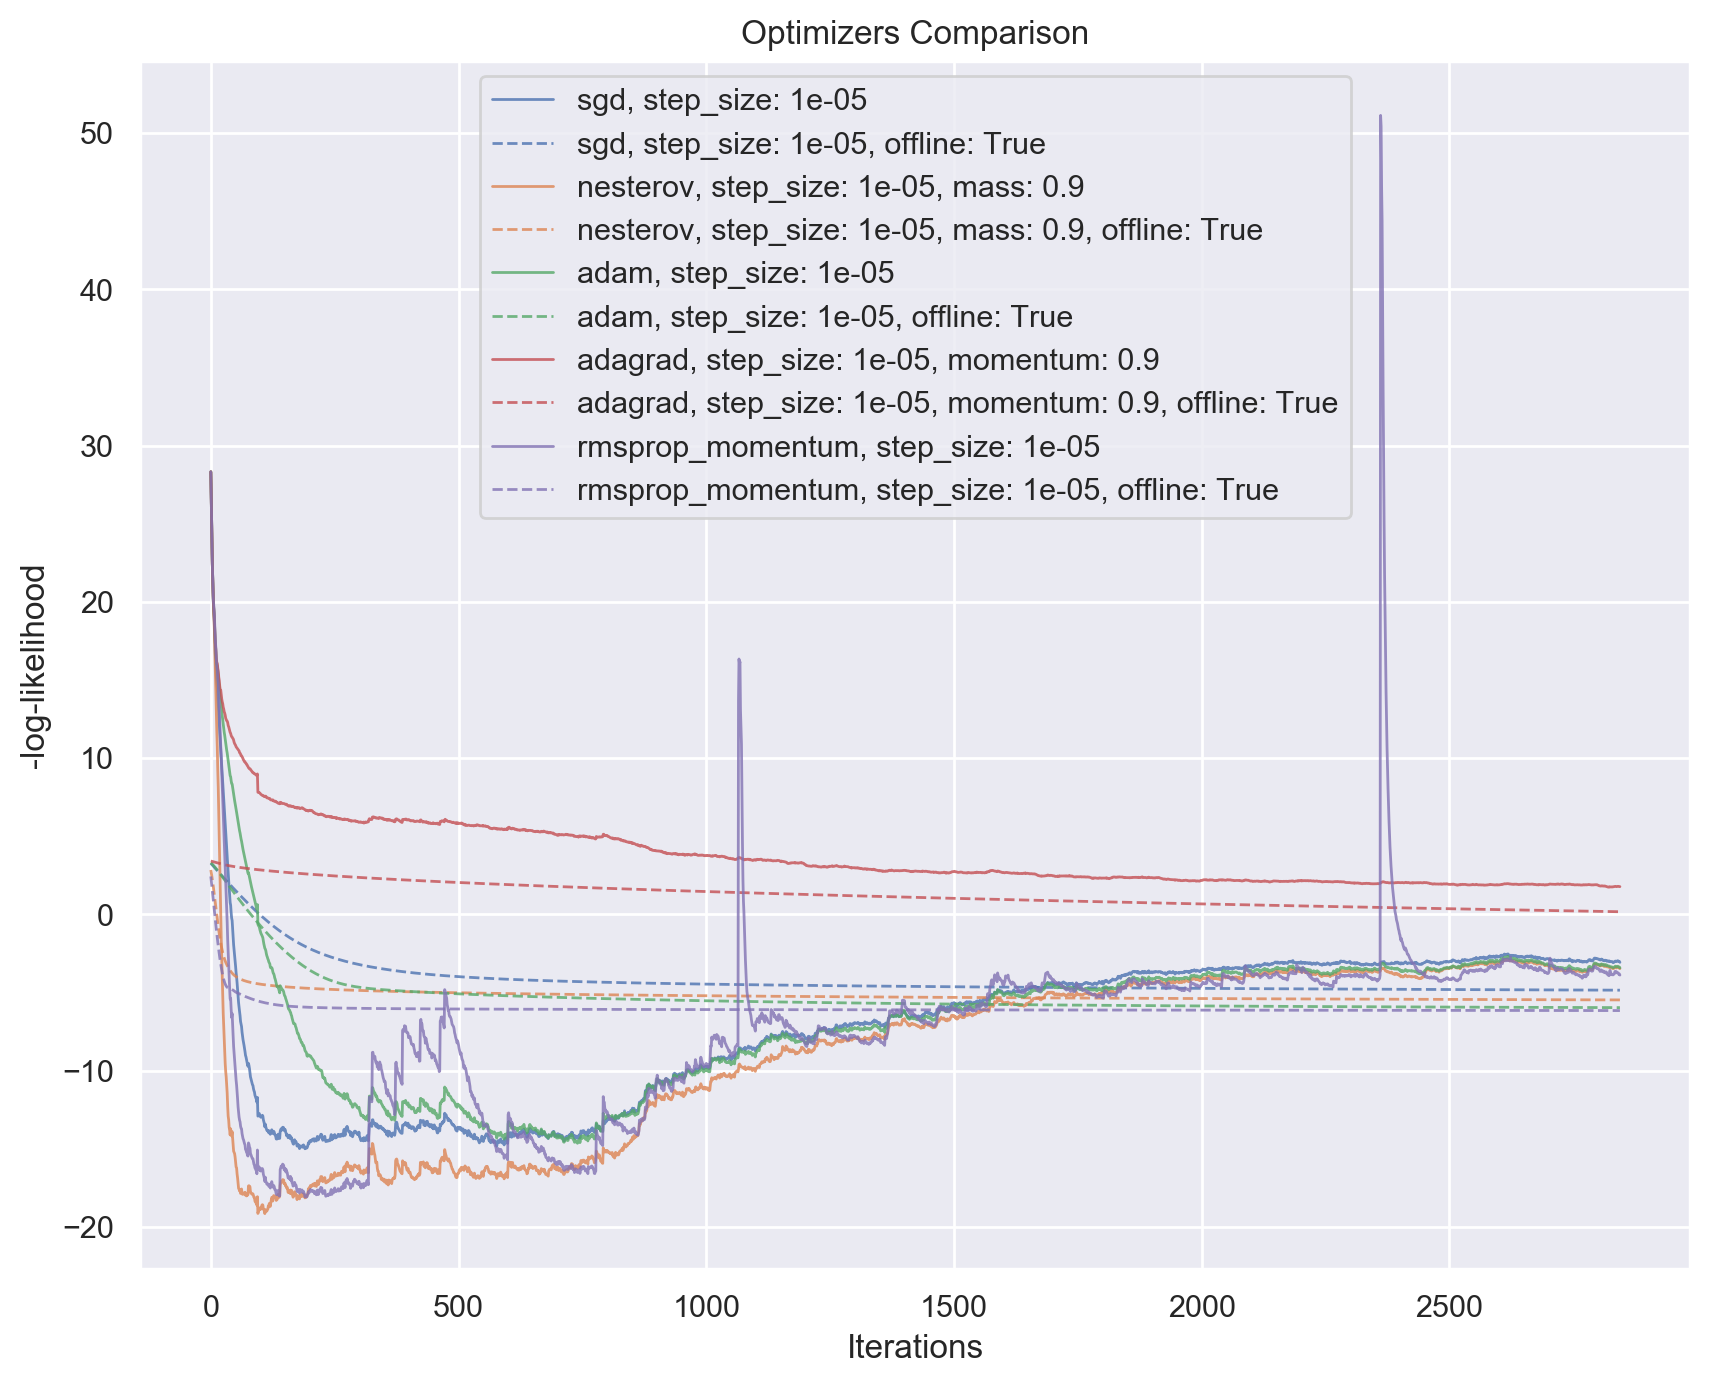

In [3]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
colors = [f'C{i}' for i in range(len(optimizers) // 2)]
for i in range(lls.shape[1]):
    if 'offline' in optimizers[i]:
        args = (lls[5:, i], colors[i//2]+'--')
    else:
        args = (lls[5:, i], colors[i//2]+'-')
    ax.plot(*args, linewidth=1, label=", ".join([f'{k}: {v}' for k, v in optimizers[i].items()])[6:], alpha=0.8)

ax.set_xlabel('Iterations')
ax.set_ylabel('-log-likelihood')
ax.set_title('Optimizers Comparison')
plt.legend()
plt.savefig('optimizer_comp.png')
plt.show()

### Results

Log-likelihood spikes in `rmsprop_momentum` were traced back to the history matrix and seemed to coincide with spikes in neuronal activity.

In [4]:
optimizers = [{'name': 'rmsprop_momentum', 'step_size': 1e-5},]
lls = c.run(optimizers, save_grad=True, save_theta=True)
g_h = [np.max(c.grad['rmsprop_momentum'][i]['h']) for i in range(len(c.y))]
y_max = [np.max(c.y[i]) for i in range(len(c.y))]

Using CPU_0
Optimizer: {'name': 'rmsprop_momentum', 'step_size': 1e-05}
rmsprop_momentum, step: 0
rmsprop_momentum, step: 100
rmsprop_momentum, step: 200
rmsprop_momentum, step: 300
rmsprop_momentum, step: 400
rmsprop_momentum, step: 500
rmsprop_momentum, step: 600
rmsprop_momentum, step: 700
rmsprop_momentum, step: 800
rmsprop_momentum, step: 900
rmsprop_momentum, step: 1000
rmsprop_momentum, step: 1100
rmsprop_momentum, step: 1200
rmsprop_momentum, step: 1300
rmsprop_momentum, step: 1400
rmsprop_momentum, step: 1500
rmsprop_momentum, step: 1600
rmsprop_momentum, step: 1700
rmsprop_momentum, step: 1800
rmsprop_momentum, step: 1900
rmsprop_momentum, step: 2000
rmsprop_momentum, step: 2100
rmsprop_momentum, step: 2200
rmsprop_momentum, step: 2300
rmsprop_momentum, step: 2400
rmsprop_momentum, step: 2500
rmsprop_momentum, step: 2600
rmsprop_momentum, step: 2700
rmsprop_momentum, step: 2800
rmsprop_momentum: 0.009797 s/step


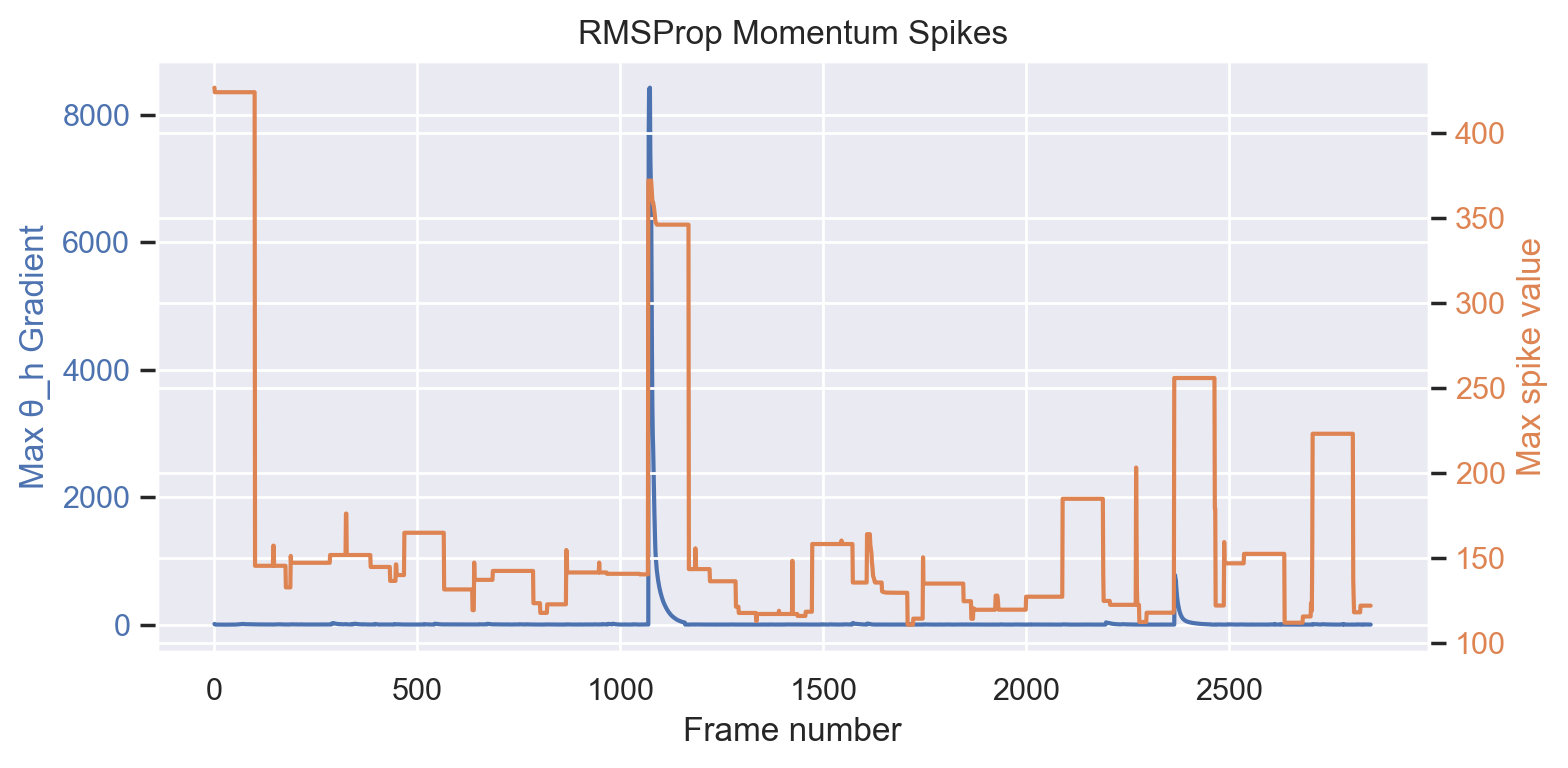

In [5]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)
ax.plot(g_h)
ax.set_xlabel('Frame number')
ax.set_ylabel('Max θ_h Gradient', color='C0')
ax.tick_params(axis='y', labelcolor='C0')
ax.set_title('RMSProp Momentum Spikes')

ax2 = ax.twinx()
ax2.plot(y_max, 'C1')
ax2.set_ylabel('Max spike value', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
fig.tight_layout()

### Hyperparameter Optimization

Bayesian hyperparameter optimization based on the Gaussian process is done using the `skopt` package. This is an example for the Nesterov optimizer. The red dashed line indicates the best performer.

In [11]:
import skopt
import skopt.plots

space = [
    skopt.space.Real(1e-6, 1e-4, name='step_size', prior='uniform'),
    skopt.space.Real(0., 1., name='mass', prior='uniform'),
]

results = c.hyper_opt('nesterov', space, n_calls=20)

Using CPU_0
Optimizer: {'name': 'nesterov', 'step_size': 5.9691617204276824e-05, 'mass': 0.8442657485810175}
nesterov, step: 0
nesterov, step: 100
nesterov, step: 200
nesterov, step: 300
nesterov, step: 400
nesterov, step: 500
nesterov, step: 600
nesterov, step: 700
nesterov, step: 800
nesterov, step: 900
nesterov, step: 1000
nesterov, step: 1100
nesterov, step: 1200
nesterov, step: 1300
nesterov, step: 1400
nesterov, step: 1500
nesterov, step: 1600
nesterov, step: 1700
nesterov, step: 1800
nesterov, step: 1900
nesterov, step: 2000
nesterov, step: 2100
nesterov, step: 2200
nesterov, step: 2300
nesterov, step: 2400
nesterov, step: 2500
nesterov, step: 2600
nesterov, step: 2700
nesterov, step: 2800
nesterov: 0.004950 s/step
Using CPU_0
Optimizer: {'name': 'nesterov', 'step_size': 8.593661614465294e-05, 'mass': 0.8472517387841256}
nesterov, step: 0
nesterov, step: 100
nesterov, step: 200
nesterov, step: 300
nesterov, step: 400
nesterov, step: 500
nesterov, step: 600
nesterov, step: 700
ne

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3f007d400>,
      dtype=object)

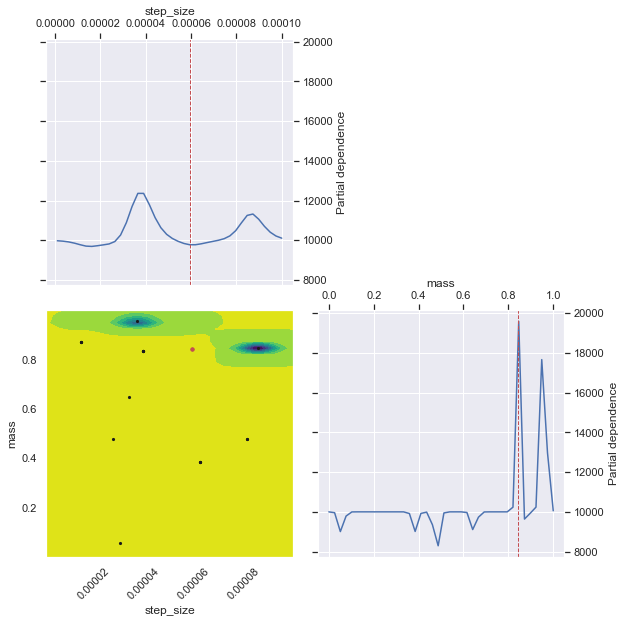

In [13]:
skopt.plots.plot_objective(results, size=4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc46ad42bb0>,
      dtype=object)

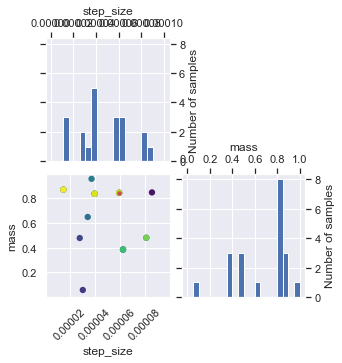

In [16]:
skopt.plots.plot_evaluations(results)